In [32]:
import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import StratifiedKFold
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.multiclass import OneVsRestClassifier

In [33]:
## Conversion jsonl to df
import pandas as pd

path = '/Users/noeamar/Documents/HEC/Jocas-HEC/Data/sampled_data_full_fields.jsonl'

df = pd.read_json(path, lines=True)
print(f"DataFrame shape: {df.shape}")
df.head()

print(df.columns.tolist())

DataFrame shape: (50000, 57)
['url', 'date_firstSeenDay', 'date_scraping', 'site_name', 'site_child', 'scrapingFailure_status', 'ID_JOCAS', 'date_firstDisappearedDay', 'date_lastSeenDay', 'MATCH_url_ID', 'MATCH_url', 'MATCH_dedup_ID', 'MATCH_dedup', 'MATCH_dedup_Tensions_ID', 'MATCH_dedup_Tensions', 'date_sitePublicationDay', 'job_title', 'job_ROME_code', 'job_qualification', 'contractType', 'contractDuration_min', 'contractDuration_max', 'contractDuration_period', 'contractDuration_value', 'workTime_hours', 'workTime_category', 'workTime_value', 'description_job', 'description_profil', 'description_entreprise', 'description_full', 'location_label', 'location_zipcode', 'location_departement', 'location_country', 'salary_min', 'salary_max', 'salary_period', 'salary_value', 'salary_hourly_mean', 'salary_hourly_min', 'salary_hourly_max', 'entreprise_nom', 'entreprise_siren', 'entrepriseSecteur_NAF88', 'entrepriseSecteur_NAF21', 'partner_name', 'partner_status', 'teleworking_accepted', 'te

## Train XGB sur donnée deja labelisée pour éviter d'utiliser des LLM

Ici on manque de données (167 labelisées mais par exemple une seule contenant "Diversity"). Donc impossible d'apprendre ici.

,Variable,Non-null,Moyenne,Écart-type,Min,25 %,50 %,75 %,Max,Unique valeurs,Coef. variation
0,location_zipcode,42733,54387.19,25951.75,1000.00,33680.00,57100.00,75000.00,99000.00,4164,0.48
1,salary_min,11659,23679.54,17902.13,9.00,18000.00,22000.00,30000.00,294000.00,502,0.76
2,salary_max,6878,32989.97,22384.57,10.30,22000.00,31000.00,44000.00,367500.00,282,0.68
3,salary_value,9671,34.73,592.69,0.07,13.38,17.12,23.34,28500.00,614,17.06
4,salary_hourly_min,9671,31.97,565.18,0.07,12.45,15.56,21.79,27000.00,429,17.68
5,salary_hourly_max,6350,39.27,630.79,0.18,15.82,21.79,28.01,30000.00,278,16.06
6,salary_hourly_mean,9671,34.73,592.69,0.07,13.38,17.12,23.34,28500.00,607,17.07
7,contractDuration_min,2172,9.81,24.46,0.00,4.00,6.00,6.00,381.00,83,2.49
8,contractDuration_max,2170,9.83,24.46,1.00,4.00,6.00,6.00,381.00,82,2.49
9,contractDuration_value,2172,130.78,98.02,0.00,65.00,130.00,130.00,780.00,96,0.75


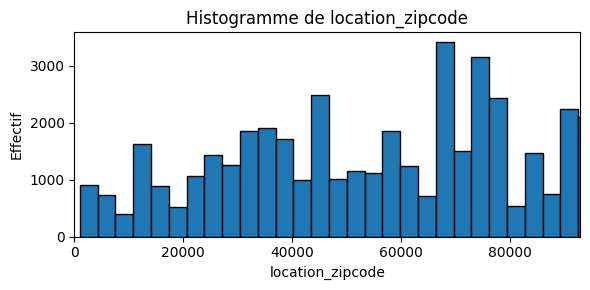

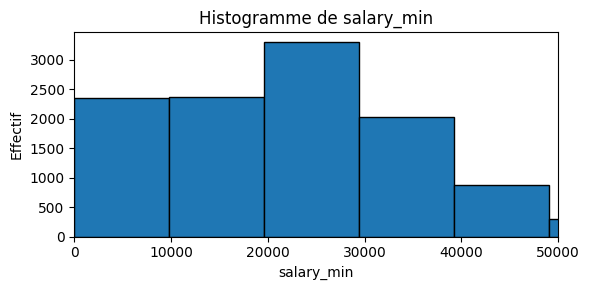

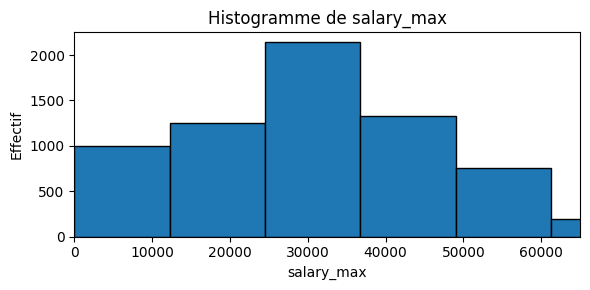

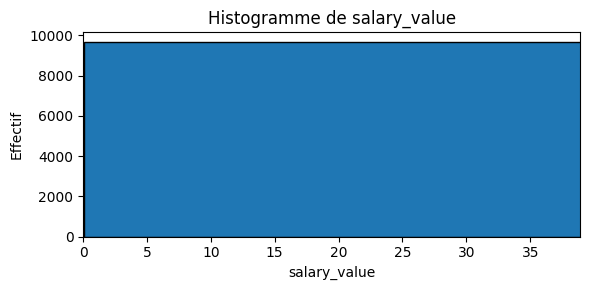

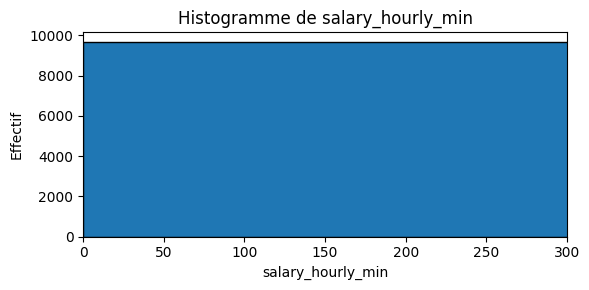

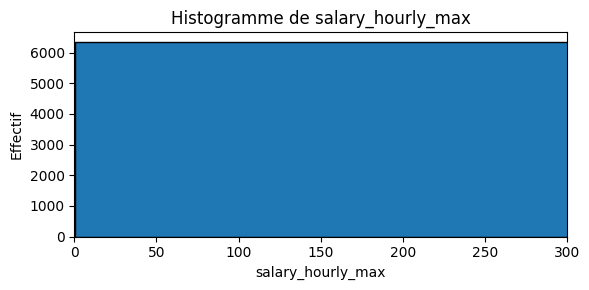

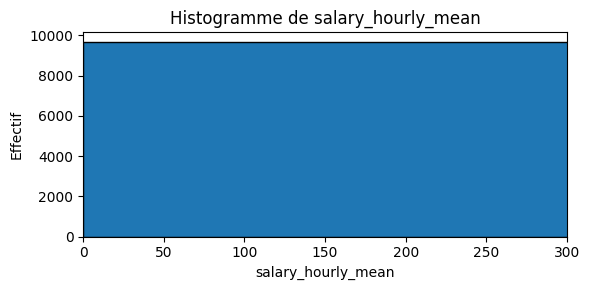

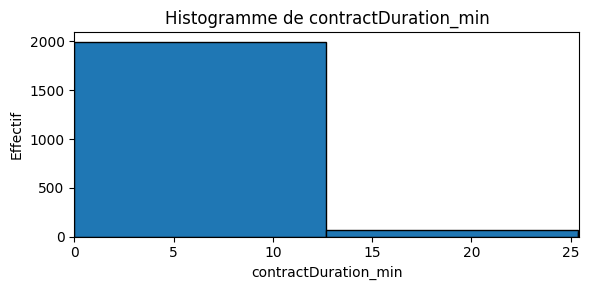

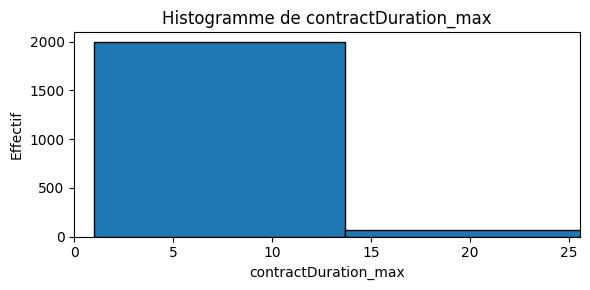

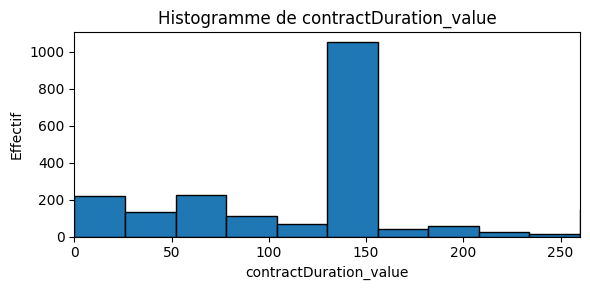

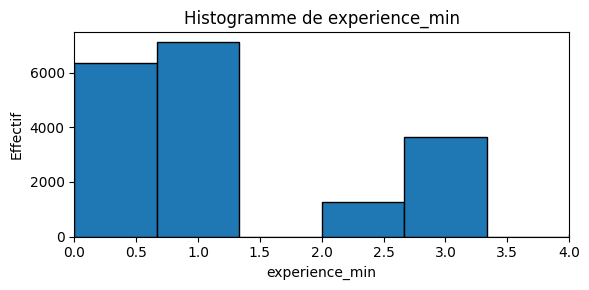

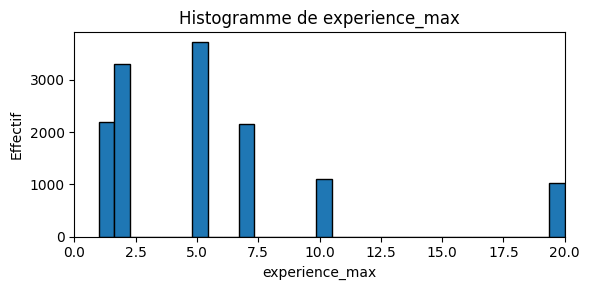

In [34]:
import json
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
from IPython.display import display
from collections import OrderedDict
from pandas.api.types import is_numeric_dtype


# 2️⃣ Lecture manuelle du JSONL
records = []
with open(path, encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            records.append(json.loads(line))
        except json.JSONDecodeError:
            continue
df = pd.DataFrame(records)

# 3️⃣ Liste des variables numériques à analyser
numeric_vars = [
    "location_zipcode", "salary_min", "salary_max", "salary_value",
    "salary_hourly_min", "salary_hourly_max", "salary_hourly_mean",
    "contractDuration_min", "contractDuration_max", "contractDuration_value",
    "workTime_hours", "experience_min", "experience_max"
]

# 4️⃣ Calcul des métriques descriptives
metrics = []
for var in numeric_vars:
    if var in df.columns and is_numeric_dtype(df[var]):
        s = pd.to_numeric(df[var], errors='coerce').dropna()
        if s.empty:
            continue
        metrics.append(OrderedDict([
            ("Variable",        var),
            ("Non-null",        int(s.count())),
            ("Moyenne",         s.mean()),
            ("Écart-type",      s.std()),
            ("Min",             s.min()),
            ("25 %",            s.quantile(0.25)),
            ("50 %",            s.median()),
            ("75 %",            s.quantile(0.75)),
            ("Max",             s.max()),
            ("Unique valeurs",   s.nunique()),
            ("Coef. variation", s.std() / s.mean() if s.mean() else float('nan'))
        ]))

metrics_df = pd.DataFrame(metrics)

# 5️⃣ Tableau stylé avec la colonne Variable visible
# Build a base styler first, then try to add background_gradient which requires matplotlib
subset_cols = ["Moyenne","Écart-type","Min","25 %","50 %","75 %","Max","Coef. variation"]
base_styler = metrics_df.style.format("{:.2f}", subset=subset_cols).set_caption("📊 Statistiques descriptives – Variables numériques")

try:
    styled = base_styler.background_gradient(subset=subset_cols, cmap="Blues")
except ImportError:
    # matplotlib not available in the current environment; fall back to base styler without gradient
    styled = base_styler

# Display the styler
display(styled)

# 6️⃣ Histogrammes avec abscisses adaptées
for var in metrics_df["Variable"]:
    s = pd.to_numeric(df[var], errors='coerce').dropna()
    if s.empty:
        continue
    
    plt.figure(figsize=(6,3))
    plt.hist(s, bins=30, edgecolor='black')
    plt.title(f"Histogramme de {var}")
    plt.xlabel(var)
    plt.ylabel("Effectif")

    # Ajustement dynamique de l'axe x
    if var.startswith("salary_hourly"):
        plt.xlim(0, 300)
    elif var.startswith("contractDuration"):
        lim = s.quantile(0.95)
        plt.xlim(0, lim)
    elif var == "salary_value":
        lim = s.quantile(0.95)
        plt.xlim(0, lim)
    else:
        lim = s.quantile(0.95)
        plt.xlim(0, lim)
    
    plt.tight_layout()
    plt.show()


,Variable,Non-null,Moyenne,Écart-type,Min,25 %,50 %,75 %,Max,Unique valeurs,Coef. variation
0,location_zipcode,42733,54387.19,25951.75,1000.00,33680.00,57100.00,75000.00,99000.00,4164,0.48
1,salary_min,11659,23679.54,17902.13,9.00,18000.00,22000.00,30000.00,294000.00,502,0.76
2,salary_max,6878,32989.97,22384.57,10.30,22000.00,31000.00,44000.00,367500.00,282,0.68
3,salary_value,9671,34.73,592.69,0.07,13.38,17.12,23.34,28500.00,614,17.06
4,salary_hourly_min,9671,31.97,565.18,0.07,12.45,15.56,21.79,27000.00,429,17.68
5,salary_hourly_max,6350,39.27,630.79,0.18,15.82,21.79,28.01,30000.00,278,16.06
6,salary_hourly_mean,9671,34.73,592.69,0.07,13.38,17.12,23.34,28500.00,607,17.07
7,contractDuration_min,2172,9.81,24.46,0.00,4.00,6.00,6.00,381.00,83,2.49
8,contractDuration_max,2170,9.83,24.46,1.00,4.00,6.00,6.00,381.00,82,2.49
9,contractDuration_value,2172,130.78,98.02,0.00,65.00,130.00,130.00,780.00,96,0.75


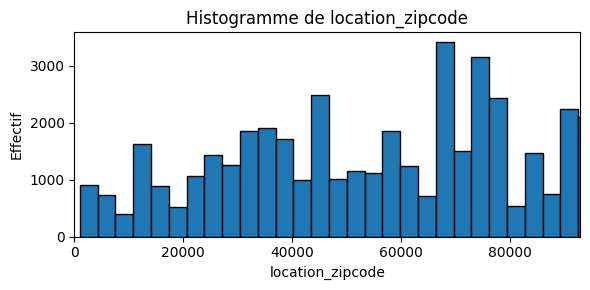

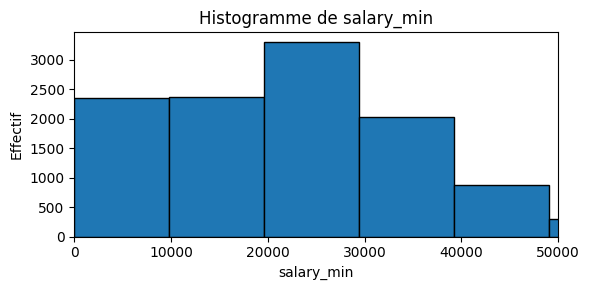

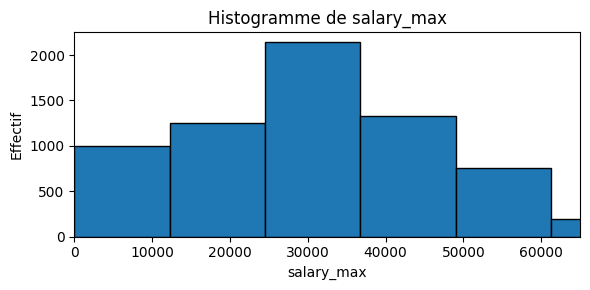

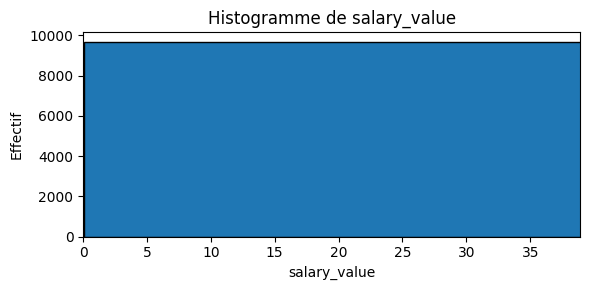

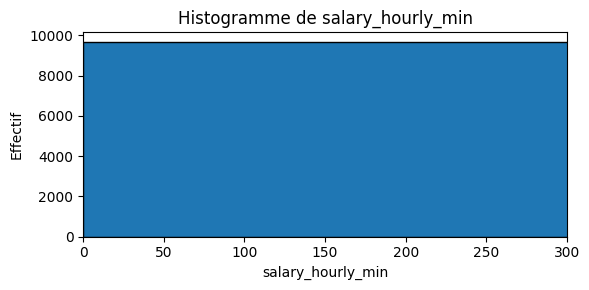

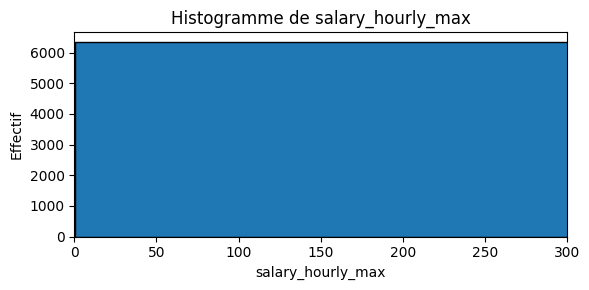

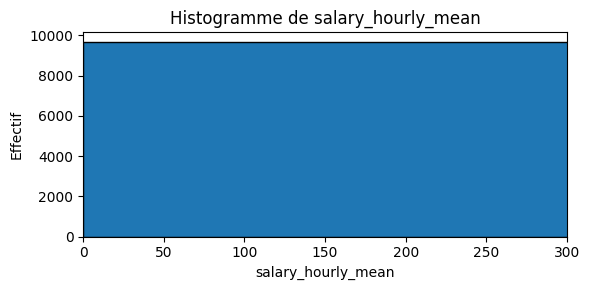

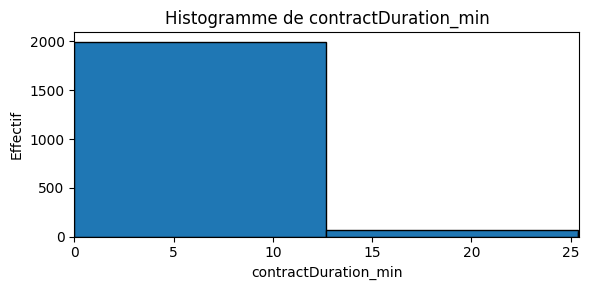

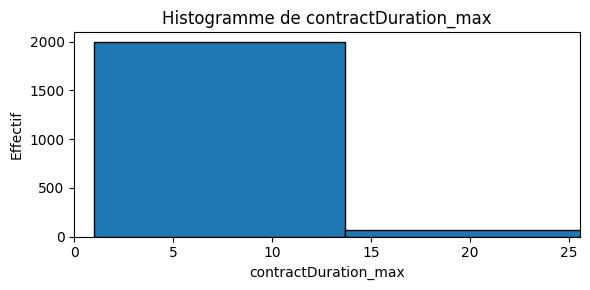

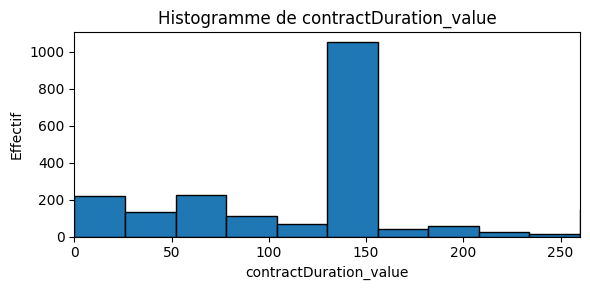

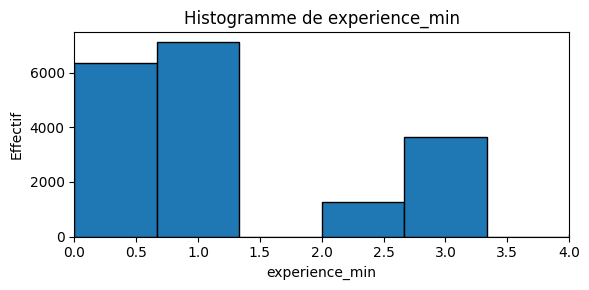

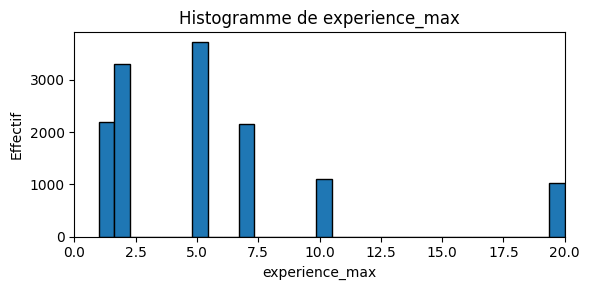

In [35]:
import json
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
from IPython.display import display
from collections import OrderedDict
from pandas.api.types import is_numeric_dtype


# 2️⃣ Lecture manuelle du JSONL
records = []
with open(path, encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            records.append(json.loads(line))
        except json.JSONDecodeError:
            continue
df = pd.DataFrame(records)

# 3️⃣ Liste des variables numériques à analyser
numeric_vars = [
    "location_zipcode", "salary_min", "salary_max", "salary_value",
    "salary_hourly_min", "salary_hourly_max", "salary_hourly_mean",
    "contractDuration_min", "contractDuration_max", "contractDuration_value",
    "workTime_hours", "experience_min", "experience_max"
]

# 4️⃣ Calcul des métriques descriptives
metrics = []
for var in numeric_vars:
    if var in df.columns and is_numeric_dtype(df[var]):
        s = pd.to_numeric(df[var], errors='coerce').dropna()
        if s.empty:
            continue
        metrics.append(OrderedDict([
            ("Variable",        var),
            ("Non-null",        int(s.count())),
            ("Moyenne",         s.mean()),
            ("Écart-type",      s.std()),
            ("Min",             s.min()),
            ("25 %",            s.quantile(0.25)),
            ("50 %",            s.median()),
            ("75 %",            s.quantile(0.75)),
            ("Max",             s.max()),
            ("Unique valeurs",   s.nunique()),
            ("Coef. variation", s.std() / s.mean() if s.mean() else float('nan'))
        ]))

metrics_df = pd.DataFrame(metrics)

# 5️⃣ Tableau stylé avec la colonne Variable visible
# Build a base styler first, then try to add background_gradient which requires matplotlib
subset_cols = ["Moyenne","Écart-type","Min","25 %","50 %","75 %","Max","Coef. variation"]
base_styler = metrics_df.style.format("{:.2f}", subset=subset_cols).set_caption("📊 Statistiques descriptives – Variables numériques")

try:
    styled = base_styler.background_gradient(subset=subset_cols, cmap="Blues")
except ImportError:
    # matplotlib not available in the current environment; fall back to base styler without gradient
    styled = base_styler

# Display the styler
display(styled)

# 6️⃣ Histogrammes avec abscisses adaptées
for var in metrics_df["Variable"]:
    s = pd.to_numeric(df[var], errors='coerce').dropna()
    if s.empty:
        continue
    
    plt.figure(figsize=(6,3))
    plt.hist(s, bins=30, edgecolor='black')
    plt.title(f"Histogramme de {var}")
    plt.xlabel(var)
    plt.ylabel("Effectif")

    # Ajustement dynamique de l'axe x
    if var.startswith("salary_hourly"):
        plt.xlim(0, 300)
    elif var.startswith("contractDuration"):
        lim = s.quantile(0.95)
        plt.xlim(0, lim)
    elif var == "salary_value":
        lim = s.quantile(0.95)
        plt.xlim(0, lim)
    else:
        lim = s.quantile(0.95)
        plt.xlim(0, lim)
    
    plt.tight_layout()
    plt.show()


## TF IDF 4K (7K training)

In [3]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# ============================================================
# 1. LOAD DATA
# ============================================================
path = "/Users/noeamar/Documents/HEC/Jocas-HEC/Data/LLM_labels.jsonl"

records = []
with open(path, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        try:
            records.append(json.loads(line))
        except:
            continue

df = pd.DataFrame(records)
print("Shape initiale :", df.shape)

# ============================================================
# 2. EXTRACTION LABELS & CONFIDENCE
# ============================================================
VALID_LABELS = [
    "DIVERSITY",
    "REMUNERATION_BENEFITS",
    "PROFESSIONAL_OPPORTUNITIES",
    "CULTURE_VALUES",
    "LEADERSHIP",
    "WORK_LIFE_BALANCE",
]

def extract_labels_and_confidence(d):
    if isinstance(d, dict) and all(k in d for k in VALID_LABELS) and "CONFIDENCE" in d:
        return {
            "vector": [d[k] for k in VALID_LABELS],
            "confidence": d["CONFIDENCE"]
        }
    return None

df["label_info"] = df["Label_All"].apply(extract_labels_and_confidence)
df = df[df["label_info"].notnull()].reset_index(drop=True)
print("Shape après filtre DICT Label_All :", df.shape)

# ============================================================
# 3. CREATION TEXTE (INPUT MODEL)
# ============================================================
TEXT_COLS = [
    "job_title",
    "description_job",
    "description_profil",
    "description_entreprise",
    "description_full",
]
df["text"] = df[TEXT_COLS].fillna("").agg(" ".join, axis=1)

# ============================================================
# 4. BOUCLE SUR CONFIDENCE [80 vs 90]
# ============================================================
for CONF_THRESHOLD in [80, 90]:
    print("\n" + "="*80)
    print(f"🔍 TEST AVEC CONFIDENCE >= {CONF_THRESHOLD}")
    print("="*80)

    # Filtre confiance
    df_tmp = df[df["label_info"].apply(lambda x: x["confidence"] >= CONF_THRESHOLD)].reset_index(drop=True)
    print("Shape après filtre confiance :", df_tmp.shape)

    # Y et X_text
    y = np.vstack(df_tmp["label_info"].apply(lambda x: x["vector"]).values).astype(int)
    X_text = df_tmp["text"].values

    print("Y shape :", y.shape)

    # TF-IDF
    vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1,2))
    X_vec = vectorizer.fit_transform(X_text)
    print("X_vec shape :", X_vec.shape)

    # ======================================================
    # 5. CROSS-VALIDATION STRATIFIÉE MULTI-LABEL
    # ======================================================
    strat_target = y.sum(axis=1)
    strat_target = np.clip(strat_target, 0, 1)

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    f1_micro_scores, f1_macro_scores = [], []
    fold = 1

    for train_idx, test_idx in kf.split(X_vec, strat_target):
        print(f"\n===== Fold {fold} =====")
        fold += 1

        X_train, X_test = X_vec[train_idx], X_vec[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = MultiOutputClassifier(
            XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.05,
                colsample_bytree=0.8,
                eval_metric="logloss",
                tree_method="hist",
            )
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        f1_micro = f1_score(y_test, y_pred, average="micro", zero_division=0)
        f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
        f1_micro_scores.append(f1_micro)
        f1_macro_scores.append(f1_macro)

        print(f"F1-micro: {f1_micro:.4f} | F1-macro: {f1_macro:.4f}")
        print("\nClassification report (fold courant) :")
        print(classification_report(y_test, y_pred, target_names=VALID_LABELS, zero_division=0))

    # ======================================================
    # 6. RÉSUMÉ FINAL
    # ======================================================
    print("\n===== 📊 RÉSUMÉ FINAL — CONF >= ", CONF_THRESHOLD, " =====")
    print(f"F1-micro mean : {np.mean(f1_micro_scores):.4f}")
    print(f"F1-macro mean : {np.mean(f1_macro_scores):.4f}")

Shape initiale : (6825, 58)
Shape après filtre DICT Label_All : (6803, 59)

🔍 TEST AVEC CONFIDENCE >= 80
Shape après filtre confiance : (1945, 60)
Y shape : (1945, 6)
X_vec shape : (1945, 8000)

===== Fold 1 =====
F1-micro: 0.8831 | F1-macro: 0.8650

Classification report (fold courant) :
                            precision    recall  f1-score   support

                 DIVERSITY       0.85      0.68      0.76       204
     REMUNERATION_BENEFITS       0.95      0.86      0.90       230
PROFESSIONAL_OPPORTUNITIES       0.85      0.93      0.89       271
            CULTURE_VALUES       0.93      0.98      0.95       340
                LEADERSHIP       0.84      0.88      0.86       216
         WORK_LIFE_BALANCE       0.96      0.72      0.82        74

                 micro avg       0.89      0.87      0.88      1335
                 macro avg       0.90      0.84      0.87      1335
              weighted avg       0.89      0.87      0.88      1335
               samples avg  

================================================================================
🔍 TEST AVEC CONFIDENCE >= 80
================================================================================
Shape après filtre confiance : (1377, 60)
Y shape : (1377, 6)
X_vec shape : (1377, 8000)

===== 📊 RÉSUMÉ FINAL — CONF >=  80  =====
F1-micro mean : 0.8781
F1-macro mean : 0.8451

Shape après filtre confiance : (1612, 60)
Y shape : (1612, 6)
X_vec shape : (1612, 8000)

===== 📊 RÉSUMÉ FINAL — CONF >=  80  =====
F1-micro mean : 0.8806
F1-macro mean : 0.8483

Shape après filtre confiance : (2090, 60)
Y shape : (2090, 6)
X_vec shape : (2090, 8000)

===== 📊 RÉSUMÉ FINAL — CONF >=  80  =====
F1-micro mean : 0.8793
F1-macro mean : 0.8562

================================================================================
🔍 TEST AVEC CONFIDENCE >= 90
================================================================================
Shape après filtre confiance : (173, 60)
Y shape : (173, 6)
X_vec shape : (173, 8000)

===== 📊 RÉSUMÉ FINAL — CONF >=  90  =====
F1-micro mean : 0.8574
F1-macro mean : 0.8179

Shape après filtre confiance : (208, 60)
Y shape : (208, 6)
X_vec shape : (208, 8000)

===== 📊 RÉSUMÉ FINAL — CONF >=  90  =====
F1-micro mean : 0.8551
F1-macro mean : 0.8227

## TF IDF 8k (4k training)

In [2]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# ---------- 1. Load JSONL ----------
path = "/Users/noeamar/Documents/HEC/Jocas-HEC/Data/LLM_labels.jsonl"

records = []
with open(path, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        try:
            records.append(json.loads(line))
        except:
            continue

df = pd.DataFrame(records)
print("Shape initiale :", df.shape)

# ---------- 2. Garder seulement les lignes avec Label_All DICT ----------
VALID_LABELS = [
    "DIVERSITY",
    "REMUNERATION_BENEFITS",
    "PROFESSIONAL_OPPORTUNITIES",
    "CULTURE_VALUES",
    "LEADERSHIP",
    "WORK_LIFE_BALANCE",
]  # ne pas inclure CONFIDENCE !

def extract_labels(d):
    if isinstance(d, dict):
        if all(k in d for k in VALID_LABELS):
            return [d[k] for k in VALID_LABELS]
    return None

df["label_vector"] = df["Label_All"].apply(extract_labels)
df = df[df["label_vector"].notnull()].reset_index(drop=True)
print("Shape après filtre Label_All :", df.shape)

# ---------- 3. Y : numpy array ----------
y = np.vstack(df["label_vector"].values).astype(int)
print("Y shape :", y.shape)

# ---------- 4. Créer la colonne texte ----------
TEXT_COLS = [
    "job_title",
    "description_job",
    "description_profil",
    "description_entreprise",
    "description_full",
]
df["text"] = df[TEXT_COLS].fillna("").agg(" ".join, axis=1)
X_text = df["text"].values

# ---------- 5. TF-IDF ----------
vectorizer = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
)
X_vec = vectorizer.fit_transform(X_text)
print("X_vec shape :", X_vec.shape)

# ---------- 6. Cross-validation stratifiée multi-label ----------
strat_target = y.sum(axis=1)
strat_target = np.clip(strat_target, 0, 1)  # binaire

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_micro_scores, f1_macro_scores = [], []
fold = 1

for train_idx, test_idx in kf.split(X_vec, strat_target):
    print(f"\n===== Fold {fold} =====")
    fold += 1

    X_train, X_test = X_vec[train_idx], X_vec[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = MultiOutputClassifier(
        XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            tree_method="hist",
        )
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1_micro = f1_score(y_test, y_pred, average="micro", zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
    f1_micro_scores.append(f1_micro)
    f1_macro_scores.append(f1_macro)

    print(f"F1-micro: {f1_micro:.4f} | F1-macro: {f1_macro:.4f}")
    print("\nClassification report (fold courant) :")
    print(classification_report(
        y_test,
        y_pred,
        target_names=VALID_LABELS,
        zero_division=0
    ))

# ---------- 7. Résultats globaux ----------
print("\n===== Résumé 5-fold CV =====")
print(f"F1-micro moyen : {np.mean(f1_micro_scores):.4f}  ± {np.std(f1_micro_scores):.4f}")
print(f"F1-macro moyen : {np.mean(f1_macro_scores):.4f}  ± {np.std(f1_macro_scores):.4f}")

Shape initiale : (6825, 58)
Shape après filtre Label_All : (6803, 59)
Y shape : (6803, 6)
X_vec shape : (6803, 8000)

===== Fold 1 =====


KeyboardInterrupt: 

## TF-IDF 8K (5K training)

In [ ]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# ---------- 1. Load JSONL ----------
path = "/Users/noeamar/Documents/HEC/Jocas-HEC/Data/LLM_labels.jsonl"

records = []
with open(path, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        try:
            records.append(json.loads(line))
        except:
            continue

df = pd.DataFrame(records)
print("Shape initiale :", df.shape)

# ---------- 2. Garder seulement les lignes avec Label_All DICT ----------
VALID_LABELS = [
    "DIVERSITY",
    "REMUNERATION_BENEFITS",
    "PROFESSIONAL_OPPORTUNITIES",
    "CULTURE_VALUES",
    "LEADERSHIP",
    "WORK_LIFE_BALANCE",
]  # ne pas inclure CONFIDENCE !

def extract_labels(d):
    if isinstance(d, dict):
        if all(k in d for k in VALID_LABELS):
            return [d[k] for k in VALID_LABELS]
    return None

df["label_vector"] = df["Label_All"].apply(extract_labels)
df = df[df["label_vector"].notnull()].reset_index(drop=True)
print("Shape après filtre Label_All :", df.shape)

# ---------- 3. Y : numpy array ----------
y = np.vstack(df["label_vector"].values).astype(int)
print("Y shape :", y.shape)

# ---------- 4. Créer la colonne texte ----------
TEXT_COLS = [
    "job_title",
    "description_job",
    "description_profil",
    "description_entreprise",
    "description_full",
]
df["text"] = df[TEXT_COLS].fillna("").agg(" ".join, axis=1)
X_text = df["text"].values

# ---------- 5. TF-IDF ----------
vectorizer = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
)
X_vec = vectorizer.fit_transform(X_text)
print("X_vec shape :", X_vec.shape)

# ---------- 6. Cross-validation stratifiée multi-label ----------
strat_target = y.sum(axis=1)
strat_target = np.clip(strat_target, 0, 1)  # binaire

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_micro_scores, f1_macro_scores = [], []
fold = 1

for train_idx, test_idx in kf.split(X_vec, strat_target):
    print(f"\n===== Fold {fold} =====")
    fold += 1

    X_train, X_test = X_vec[train_idx], X_vec[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = MultiOutputClassifier(
        XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            tree_method="hist",
        )
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1_micro = f1_score(y_test, y_pred, average="micro", zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
    f1_micro_scores.append(f1_micro)
    f1_macro_scores.append(f1_macro)

    print(f"F1-micro: {f1_micro:.4f} | F1-macro: {f1_macro:.4f}")
    print("\nClassification report (fold courant) :")
    print(classification_report(
        y_test,
        y_pred,
        target_names=VALID_LABELS,
        zero_division=0
    ))

# ---------- 7. Résultats globaux ----------
print("\n===== Résumé 5-fold CV =====")
print(f"F1-micro moyen : {np.mean(f1_micro_scores):.4f}  ± {np.std(f1_micro_scores):.4f}")
print(f"F1-macro moyen : {np.mean(f1_macro_scores):.4f}  ± {np.std(f1_macro_scores):.4f}")

Shape initiale : (4972, 58)
Shape après filtre Label_All : (4955, 59)
Y shape : (4955, 6)
X_vec shape : (4955, 8000)

===== Fold 1 =====
F1-micro: 0.8473 | F1-macro: 0.8135

Classification report (fold courant) :
                            precision    recall  f1-score   support

                 DIVERSITY       0.87      0.56      0.68       409
     REMUNERATION_BENEFITS       0.91      0.80      0.85       395
PROFESSIONAL_OPPORTUNITIES       0.84      0.78      0.81       515
            CULTURE_VALUES       0.92      0.97      0.94       840
                LEADERSHIP       0.85      0.83      0.84       504
         WORK_LIFE_BALANCE       0.98      0.61      0.75        95

                 micro avg       0.89      0.81      0.85      2758
                 macro avg       0.90      0.76      0.81      2758
              weighted avg       0.89      0.81      0.84      2758
               samples avg       0.86      0.79      0.80      2758


===== Fold 2 =====
F1-micro: 0.8428

### TF IDF 15k (4K training)

In [ ]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from xgboost import XGBClassifier

# ---------- 1. Load JSONL ----------
path = "/Users/noeamar/Documents/HEC/Jocas-HEC/Data/LLM_labels.jsonl"

records = []
with open(path, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        try:
            records.append(json.loads(line))
        except:
            continue

df = pd.DataFrame(records)
print("Shape initiale :", df.shape)

# ---------- 2. Garder seulement les lignes avec Label_All DICT ----------
VALID_LABELS = [
    "DIVERSITY",
    "REMUNERATION_BENEFITS",
    "PROFESSIONAL_OPPORTUNITIES",
    "CULTURE_VALUES",
    "LEADERSHIP",
    "WORK_LIFE_BALANCE",
]

def extract_labels(d):
    if isinstance(d, dict) and all(k in d for k in VALID_LABELS):
        return [d[k] for k in VALID_LABELS]
    return None

df["label_vector"] = df["Label_All"].apply(extract_labels)
df = df[df["label_vector"].notnull()].reset_index(drop=True)
print("Shape après filtre Label_All :", df.shape)

# ---------- 3. Y : numpy array ----------
y = np.vstack(df["label_vector"].values).astype(int)
print("Y shape :", y.shape)

# ---------- 4. Texte ----------
TEXT_COLS = [
    "job_title", "description_job", "description_profil",
    "description_entreprise", "description_full",
]
df["text"] = df[TEXT_COLS].fillna("").agg(" ".join, axis=1)
X_text = df["text"].values

# ---------- 5. TF-IDF ----------
vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1, 2))
X_vec = vectorizer.fit_transform(X_text)
print("X_vec shape :", X_vec.shape)

# ---------- 6. Calcul scale_pos_weight par label ----------
scale_weights = []
for i, label in enumerate(VALID_LABELS):
    n_pos = (y[:, i] == 1).sum()
    n_neg = (y[:, i] == 0).sum()
    weight = n_neg / max(n_pos, 1)  # éviter /0
    scale_weights.append(weight)
    print(f"{label}: scale_pos_weight = {weight:.2f}")

# ----------
# 7. Cross-validation stratifiée multi-label
# ----------
strat_target = y.sum(axis=1)
strat_target = np.clip(strat_target, 0, 1)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_micro_scores, f1_macro_scores = [], []
fold = 1

for train_idx, test_idx in kf.split(X_vec, strat_target):
    print(f"\n===== Fold {fold} =====")
    fold += 1

    X_train, X_test = X_vec[train_idx], X_vec[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # ========= TRAIN MANUEL PAR LABEL =========
    y_pred = np.zeros_like(y_test)

    for i, label in enumerate(VALID_LABELS):
        xgb = XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            tree_method="hist",
            scale_pos_weight=scale_weights[i],  # ⭐ KEY POINT
        )

        xgb.fit(X_train, y_train[:, i])
        y_pred[:, i] = xgb.predict(X_test)

    # ========= EVALUATION =========
    f1_micro = f1_score(y_test, y_pred, average="micro", zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
    f1_micro_scores.append(f1_micro)
    f1_macro_scores.append(f1_macro)

    print(f"F1-micro: {f1_micro:.4f} | F1-macro: {f1_macro:.4f}")
    print("\nClassification report :")
    print(classification_report(y_test, y_pred, target_names=VALID_LABELS, zero_division=0))

# ---------- 8. Résultats globaux ----------
print("\n===== Résumé 5-fold CV =====")
print(f"F1-micro moyen : {np.mean(f1_micro_scores):.4f}")
print(f"F1-macro moyen : {np.mean(f1_macro_scores):.4f}")

Shape initiale : (4002, 58)
Shape après filtre Label_All : (3988, 59)
Y shape : (3988, 6)
X_vec shape : (3988, 15000)
DIVERSITY: scale_pos_weight = 1.27
REMUNERATION_BENEFITS: scale_pos_weight = 1.57
PROFESSIONAL_OPPORTUNITIES: scale_pos_weight = 0.83
CULTURE_VALUES: scale_pos_weight = 0.18
LEADERSHIP: scale_pos_weight = 1.01
WORK_LIFE_BALANCE: scale_pos_weight = 10.14

===== Fold 1 =====
F1-micro: 0.8414 | F1-macro: 0.8099

Classification report :
                            precision    recall  f1-score   support

                 DIVERSITY       0.83      0.63      0.71       361
     REMUNERATION_BENEFITS       0.88      0.78      0.83       292
PROFESSIONAL_OPPORTUNITIES       0.87      0.79      0.83       436
            CULTURE_VALUES       0.95      0.90      0.92       676
                LEADERSHIP       0.85      0.84      0.85       408
         WORK_LIFE_BALANCE       0.79      0.66      0.72        62

                 micro avg       0.88      0.80      0.84      2235
 

## TF IDF 8K (4K training + grid search)

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# ========= PARAMETRES =========
USE_EMBEDDINGS = False        #  <<<<<<<<<< CHANGER ICI
GRID_SEARCH = True           #  <<<<<<<<<< OPTIMISATION AUTO SI > 50 labels
RANDOM_STATE = 42

# ---------- 1. Load JSONL ----------
path = "/Users/noeamar/Documents/HEC/Jocas-HEC/Data/LLM_labels.jsonl"

records = []
with open(path, "r", encoding="utf-8") as f:
    for line in f:
        if line.strip():
            try:
                records.append(json.loads(line))
            except:
                continue

df = pd.DataFrame(records)
print("Shape initiale :", df.shape)

# ---------- 2. Extraction labels ----------
VALID_LABELS = [
    "DIVERSITY",
    "REMUNERATION_BENEFITS",
    "PROFESSIONAL_OPPORTUNITIES",
    "CULTURE_VALUES",
    "LEADERSHIP",
    "WORK_LIFE_BALANCE",
]

def extract_labels(d):
    if isinstance(d, dict) and all(k in d for k in VALID_LABELS):
        return [d[k] for k in VALID_LABELS]
    return None

df["label_vector"] = df["Label_All"].apply(extract_labels)
df = df[df["label_vector"].notnull()].reset_index(drop=True)
print("Shape après filtre :", df.shape)

y = np.vstack(df["label_vector"].values).astype(int)
print("Y shape :", y.shape)

# ---------- 3. Création du texte ----------
TEXT_COLS = [
    "job_title",
    "description_job",
    "description_profil",
    "description_entreprise",
    "description_full",
]
df["text"] = df[TEXT_COLS].fillna("").agg(" ".join, axis=1)

# ====================== OPTION 1 : TF-IDF ======================
if not USE_EMBEDDINGS:
    vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1, 2))
    X = vectorizer.fit_transform(df["text"].values)
    print(">> TF-IDF utilisé :", X.shape)

# ====================== OPTION 2 : EMBEDDINGS ======================
else:
    print(">> SentenceTransformer en cours...")
    embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    X = embedder.encode(df["text"].tolist(), show_progress_bar=True)
    print(">> Embeddings shape :", X.shape)

# ---------- 4. Grid Search XGBoost ? ----------
base_model = XGBClassifier(
    eval_metric="logloss",
    tree_method="hist",
    random_state=RANDOM_STATE
)

if GRID_SEARCH and len(df) > 50:  # pour éviter trop long si mini dataset
    param_grid = {
        "estimator__n_estimators": [200, 400],
        "estimator__max_depth": [4, 6],
        "estimator__learning_rate": [0.03, 0.05],
        "estimator__subsample": [0.8, 1.0],
        "estimator__colsample_bytree": [0.8, 1.0],
    }

    model = MultiOutputClassifier(base_model)

    search = GridSearchCV(
        model,
        param_grid=param_grid,
        cv=2,
        scoring="f1_micro",
        n_jobs=-1,
        verbose=2,
    )
    search.fit(X, y)

    print("\n🔥 BEST PARAMS from Grid Search:")
    print(search.best_params_)
    model = search.best_estimator_
else:
    model = MultiOutputClassifier(base_model)

# ---------- 5. Cross Validation ----------
strat_target = np.clip(y.sum(axis=1), 0, 1)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

micro_scores, macro_scores = [], []
fold = 1

for train_idx, test_idx in kf.split(X, strat_target):
    print(f"\n===== Fold {fold} =====")
    fold += 1
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1_micro = f1_score(y_test, y_pred, average="micro", zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)

    micro_scores.append(f1_micro)
    macro_scores.append(f1_macro)

    print(f"F1-micro: {f1_micro:.4f} | F1-macro: {f1_macro:.4f}")
    print(classification_report(y_test, y_pred, target_names=VALID_LABELS, zero_division=0))

print("\n===== Résumé FINAL =====")
print(f"F1-micro mean : {np.mean(micro_scores):.4f}")
print(f"F1-macro mean : {np.mean(macro_scores):.4f}")

/Users/noeamar/Documents/HEC/.jocas_hec/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Shape initiale : (4002, 58)
Shape après filtre : (3988, 59)
Y shape : (3988, 6)
>> TF-IDF utilisé : (3988, 8000)
Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.03, estimator__max_depth=4, estimator__n_estimators=200, estimator__subsample=1.0; total time=  57.2s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.03, estimator__max_depth=4, estimator__n_estimators=200, estimator__subsample=0.8; total time=  57.3s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.03, estimator__max_depth=4, estimator__n_estimators=200, estimator__subsample=0.8; total time= 1.4min
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.03, estimator__max_depth=4, estimator__n_estimators=200, estimator__subsample=1.0; total time= 1.4min
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.03, estimator__max_depth=6, estimator__n_estimators=200, estimator__subsa

/Users/noeamar/Documents/HEC/.jocas_hec/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.03, estimator__max_depth=6, estimator__n_estimators=400, estimator__subsample=0.8; total time= 6.6min
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.05, estimator__max_depth=6, estimator__n_estimators=200, estimator__subsample=0.8; total time= 3.6min
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.05, estimator__max_depth=4, estimator__n_estimators=400, estimator__subsample=1.0; total time= 3.9min
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.03, estimator__max_depth=6, estimator__n_estimators=400, estimator__subsample=1.0; total time= 6.6min
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.05, estimator__max_depth=6, estimator__n_estimators=200, estimator__subsample=1.0; total time= 2.6min
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.05, estimator__max_depth=6, estimator__n_estimators=200, estimator__subsampl

## Embedder (4K training)

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# ========= PARAMETRES =========
USE_EMBEDDINGS = True        #  <<<<<<<<<< CHANGER ICI
GRID_SEARCH = False           #  <<<<<<<<<< OPTIMISATION AUTO SI > 50 labels
RANDOM_STATE = 42

# ---------- 1. Load JSONL ----------
path = "/Users/noeamar/Documents/HEC/Jocas-HEC/Data/LLM_labels.jsonl"

records = []
with open(path, "r", encoding="utf-8") as f:
    for line in f:
        if line.strip():
            try:
                records.append(json.loads(line))
            except:
                continue

df = pd.DataFrame(records)
print("Shape initiale :", df.shape)

# ---------- 2. Extraction labels ----------
VALID_LABELS = [
    "DIVERSITY",
    "REMUNERATION_BENEFITS",
    "PROFESSIONAL_OPPORTUNITIES",
    "CULTURE_VALUES",
    "LEADERSHIP",
    "WORK_LIFE_BALANCE",
]

def extract_labels(d):
    if isinstance(d, dict) and all(k in d for k in VALID_LABELS):
        return [d[k] for k in VALID_LABELS]
    return None

df["label_vector"] = df["Label_All"].apply(extract_labels)
df = df[df["label_vector"].notnull()].reset_index(drop=True)
print("Shape après filtre :", df.shape)

y = np.vstack(df["label_vector"].values).astype(int)
print("Y shape :", y.shape)

# ---------- 3. Création du texte ----------
TEXT_COLS = [
    "job_title",
    "description_job",
    "description_profil",
    "description_entreprise",
    "description_full",
]
df["text"] = df[TEXT_COLS].fillna("").agg(" ".join, axis=1)

# ====================== OPTION 1 : TF-IDF ======================
if not USE_EMBEDDINGS:
    vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1, 2))
    X = vectorizer.fit_transform(df["text"].values)
    print(">> TF-IDF utilisé :", X.shape)

# ====================== OPTION 2 : EMBEDDINGS ======================
else:
    print(">> SentenceTransformer en cours...")
    embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    X = embedder.encode(df["text"].tolist(), show_progress_bar=True)
    print(">> Embeddings shape :", X.shape)

# ---------- 4. Grid Search XGBoost ? ----------
base_model = XGBClassifier(
    eval_metric="logloss",
    tree_method="hist",
    random_state=RANDOM_STATE
)

if GRID_SEARCH and len(df) > 50:  # pour éviter trop long si mini dataset
    param_grid = {
        "estimator__n_estimators": [200, 400],
        "estimator__max_depth": [4, 6],
        "estimator__learning_rate": [0.03, 0.05],
        "estimator__subsample": [0.8, 1.0],
        "estimator__colsample_bytree": [0.8, 1.0],
    }

    model = MultiOutputClassifier(base_model)

    search = GridSearchCV(
        model,
        param_grid=param_grid,
        cv=2,
        scoring="f1_micro",
        n_jobs=-1,
        verbose=2,
    )
    search.fit(X, y)

    print("\n🔥 BEST PARAMS from Grid Search:")
    print(search.best_params_)
    model = search.best_estimator_
else:
    model = MultiOutputClassifier(base_model)

# ---------- 5. Cross Validation ----------
strat_target = np.clip(y.sum(axis=1), 0, 1)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

micro_scores, macro_scores = [], []
fold = 1

for train_idx, test_idx in kf.split(X, strat_target):
    print(f"\n===== Fold {fold} =====")
    fold += 1
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1_micro = f1_score(y_test, y_pred, average="micro", zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)

    micro_scores.append(f1_micro)
    macro_scores.append(f1_macro)

    print(f"F1-micro: {f1_micro:.4f} | F1-macro: {f1_macro:.4f}")
    print(classification_report(y_test, y_pred, target_names=VALID_LABELS, zero_division=0))

print("\n===== Résumé FINAL =====")
print(f"F1-micro mean : {np.mean(micro_scores):.4f}")
print(f"F1-macro mean : {np.mean(macro_scores):.4f}")

Shape initiale : (4002, 58)
Shape après filtre : (3988, 59)
Y shape : (3988, 6)
>> SentenceTransformer en cours...


Batches: 100%|██████████| 125/125 [00:32<00:00,  3.88it/s]


>> Embeddings shape : (3988, 384)

===== Fold 1 =====
F1-micro: 0.7551 | F1-macro: 0.6508
                            precision    recall  f1-score   support

                 DIVERSITY       0.73      0.55      0.63       600
     REMUNERATION_BENEFITS       0.68      0.64      0.66       492
PROFESSIONAL_OPPORTUNITIES       0.69      0.73      0.71       708
            CULTURE_VALUES       0.85      0.98      0.91      1117
                LEADERSHIP       0.76      0.71      0.73       677
         WORK_LIFE_BALANCE       0.77      0.15      0.26       110

                 micro avg       0.76      0.75      0.76      3704
                 macro avg       0.75      0.63      0.65      3704
              weighted avg       0.76      0.75      0.74      3704
               samples avg       0.76      0.74      0.71      3704


===== Fold 2 =====
F1-micro: 0.7556 | F1-macro: 0.6519
                            precision    recall  f1-score   support

                 DIVERSITY       0

In [ ]:
print(pd.DataFrame(y, columns=VALID_LABELS).sum())

DIVERSITY                     1452
REMUNERATION_BENEFITS         1188
PROFESSIONAL_OPPORTUNITIES    1704
CULTURE_VALUES                2559
LEADERSHIP                    1473
WORK_LIFE_BALANCE              271
dtype: int64
